
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [1700]:
import autograd.numpy as np 
import matplotlib.pyplot as plt
from fgbuster import CMB, Dust, Synchrotron, MixingMatrix
from fgbuster.observation_helpers import standardize_instrument, get_observation
from fgbuster.cosmology import _get_Cl_cmb, _get_Cl_noise
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import healpy as hp
import numdifftools.core as nd
import math as m
from fgbuster.algebra import  W_dBdB, W_dB, W, _mmm, _utmv, _mmv, comp_sep



## 1.general parameters

In [1701]:
nside = 64
model = 'd0s0'

Load the instrument

In [1702]:
instr = np.load('/Users/alicepirotta/Desktop/APC/MCMC/instrument_LB_IMOv1.npy', allow_pickle=True).item()
instr_ = {}
instr_['frequency'] = np.array([instr[f]['freq'] for f in instr.keys()])
instr_['depth_p'] = np.array([instr[f]['P_sens'] for f in instr.keys()])
instr_['fwhm'] = np.array([instr[f]['beam'] for f in instr.keys()])
instr_['depth_i'] = instr_['depth_p']/np.sqrt(2)
instrument = standardize_instrument(instr_)

n_freqs=len(instrument.frequency)
n_stokes=3

Get the frequency maps 

In [1703]:
d_fgs_N = get_observation(instrument, model, noise=True, nside=nside)
d_fgs = get_observation(instrument, model, noise=False, nside=nside)

#take only the Q and U, not I
freq_maps_N= d_fgs_N[:,1:,:]
freq_maps= d_fgs[:,1:,:]


Chose the components to fit for

In [1704]:
components= [CMB(), Dust(150.), Synchrotron(150.)]

In [1705]:
M = MixingMatrix(*components) 
M_ev = M.evaluator(instrument.frequency)


Define the noise covariance matrix

In [1706]:
N = np.diag((instrument.depth_p / hp.nside2resol(nside, arcmin=True))**2)
invN = np.linalg.inv(N)


## 2.component separation

true and initial values for the parameters

In [1707]:
gains_true = np.ones(21)
x_true = np.concatenate((M.defaults, gains_true))

x_init = np.random.uniform(low=x_true * (1 - 1 / 40), high= x_true * (1 + 1 / 40))

#### average spectral likelihood

In [1708]:
dati = np.einsum('ijp,klp-> ijkl',freq_maps,freq_maps)
print(M_ev(np.array([1.54,20,-3])).shape)


(22, 3)


In [1709]:
def aver_likelihood(y):
    Bd, T, Bs, a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, s, t, u, v, w, z = y
    r= 1
    G = np.diag([a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z ])
    A_maxL =G.dot(M_ev(np.array([Bd,T,Bs]))) 
    logL = 0
    AtN = A_maxL.T.dot(invN)
    NA= invN.dot(A_maxL)
    AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
    P = NA.dot(AtNA).dot(AtN)
    logL = logL -np.trace(np.einsum('fg, gikj->fk', P, dati)+np.einsum('fg, ij->gi', P, N))

    if logL != logL:
        return 0.0
    return logL

In [1710]:
aver_likelihood(x_true)

-31300490262.32101

#### step1: minimization of the average spectral likelihood

In [1711]:
bnds = ((1.4, 1.6), (10, 30), (-3.5,-2.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5))
options={'maxfun':50000}
result= minimize(aver_likelihood, x_true, method='TNC', tol = 1e-18, options=options, bounds=bnds )
print(result)
print(result.x)

 message: Converged (|f_n-f_(n-1)| ~= 0)
 success: True
  status: 1
     fun: -31300490262.32105
       x: [ 1.540e+00  2.000e+01 ...  1.000e+00  1.000e+00]
     nit: 4
     jac: [ 3.815e+02  3.815e+02 ...  7.629e+02  3.815e+02]
    nfev: 1325
[ 1.54       20.00000008 -2.99999996  1.00000019  0.99999998  1.00000014
  0.99999997  0.99999998  1.00000006  0.99999995  1.          0.99999992
  1.00000001  0.99999998  1.          0.99999995  0.99999995  1.00000003
  0.99999998  1.00000004  1.00000005  0.99999998  1.00000007  0.99999998]


Calculate the errors of the parameters

In [1712]:
H = nd.Hessian(aver_likelihood)
h = H(result.x)

sigma_params_square = np.linalg.inv(h)
print(sigma_params_square)

#Hessian should be only 3,3

[[-3.33000390e-02  4.16480756e-01 -3.18597802e-02 -4.37273390e-02
  -3.66546979e-02 -3.08970697e-02 -2.69634230e-02 -2.69634208e-02
  -2.26787995e-02 -2.26787943e-02 -1.85942046e-02 -1.85942002e-02
  -1.50208759e-02 -9.75874544e-03 -4.93592247e-03 -1.50208742e-02
  -9.75874486e-03 -4.93592279e-03  4.52794099e-03  4.52794149e-03
   9.56741226e-03  1.40462468e-02  1.84456144e-02  2.22260114e-02]
 [ 4.16480746e-01 -1.81494203e+01  3.43750719e-01  4.23067950e-01
   3.47803931e-01  2.87230663e-01  2.46459740e-01  2.46459717e-01
   2.02885558e-01  2.02885511e-01  1.62396038e-01  1.62395998e-01
   1.28016948e-01  7.96256600e-02  3.82946206e-02  1.28016933e-01
   7.96256554e-02  3.82946231e-02 -3.03350951e-02 -3.03350984e-02
  -5.65742996e-02 -7.02862722e-02 -7.01714115e-02 -5.23776212e-02]
 [-3.18597803e-02  3.43750730e-01 -2.86808234e-02 -4.03230537e-02
  -3.39226855e-02 -2.87106086e-02 -2.51447485e-02 -2.51447465e-02
  -2.12430736e-02 -2.12430687e-02 -1.74940069e-02 -1.74940027e-02
  -1.418

definition of A=G*M

In [1713]:
def G_tot(gain_params):
    a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, s, t, u, v, w, z = gain_params
    r= 1
    G = np.diag([a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z ])
    return G

In [1714]:
#modified
def A_ev_new(y):
    Bd, T, Bs, a, b, c, d, e, f, g, i, l, m, n, o, p, q, r, s, t, u, v, w, z = y
    h = 1
    G = np.diag([a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z ])
    A_maxL =G.dot(M_ev(np.array([Bd,T,Bs])))
    print(A_maxL.shape)
    return A_maxL

In [1715]:
#evaluate the matrix A at maximum of the average likelihood

A_maxL=A_ev_new(result.x) #(n_freq,n_component) #modified
print(A_maxL.shape)


(22, 3)
(22, 3)


#### step2: take the component maps (residual, dust, synch)
the first one should be CMB, but I have no CMB, so it is residual

In [1716]:
AtN=A_maxL.T.dot(invN)
AtNA=np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
comp_maps=np.einsum ('cg,gs,sij->cij', AtNA,AtN, freq_maps)


W_maxL = np.einsum ('cg,gs->cs', AtNA,AtN)


residual_maps_QU = comp_maps[0]
zeros=np.zeros((1, 49152))
residual_maps_IQU = np.vstack((zeros, residual_maps_QU))


## 3. total residual power spectrum

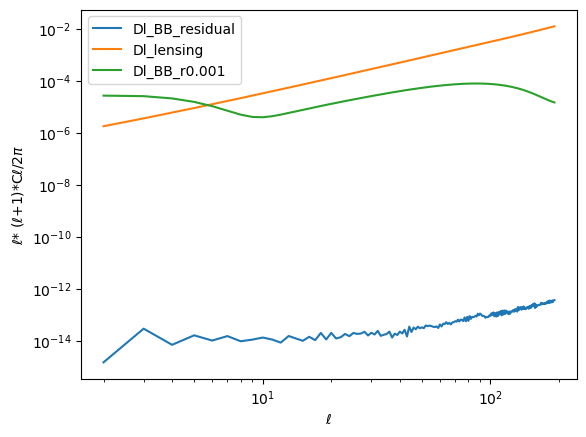

In [1717]:
#multipole range 
lmin= 2
lmax= 192
ell = np.arange(lmin,lmax)


#power spectrum of the total residual 
Cl_BB_residual =hp.anafast(residual_maps_IQU)[2,lmin:] #with [2] I select the B mode #closed to bias
Dl_BB_residual = (ell*(ell+1)*Cl_BB_residual)/(2*m.pi)


#Cl theory 
Cl_BB_r1 = _get_Cl_cmb(Alens=0.0, r=1.)[2][lmin:lmax]
Cl_BB_r_001 = _get_Cl_cmb(Alens=0.0, r=0.001)[2] [lmin:lmax]

#Dl theory
Dl_BB_r001 = (ell*(ell+1)*Cl_BB_r_001)/(2*m.pi)


#lensing
Cl_lens = _get_Cl_cmb(Alens=1.0, r=0.)[2][lmin:lmax]
Dl_lens = (ell*(ell+1)*Cl_lens)/(2*m.pi)

#plot power spectra
plt.loglog(ell, Dl_BB_residual, label = "Dl_BB_residual")
plt.loglog(ell, Dl_lens, label = "Dl_lensing")
plt.loglog(ell, Dl_BB_r001, label = "Dl_BB_r0.001")
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell$* ($\ell$+1)*C$\ell$/2$\pi$')
plt.legend()



## 4.Calculate sigma Fisher

In [1718]:
Data = Cl_BB_residual + Cl_lens #it is needed by the cosmological likelihood
fsky = 1
F = np.sum((2*ell+1) * fsky / 2*Cl_BB_r1** 2 / Data ** 2) #it is a scalar because I am using comsological likelihood
sigma_r_fisher = np.sqrt(1.0 / F)

In [1719]:
i_cmb = M.components.index('CMB')

#residual (n_component,n_freq)
W_maxL = np.einsum ('cg,gs->cs', AtNA,AtN)[i_cmb,:]



#this function takes the gain parameters 21 from the minimization and add the one that is fixed at 1
def G_values_tot(gain_params):
    a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, s, t, u, v, w, z = gain_params
    r= 1
    G = [a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z]
    return G

gain_params_tot= G_values_tot(result.x[3:])
# gain_params_tot= G_values_tot(np.ones(21))  #modified


#it gives you the derivative of the gain respect to each gains
def G_diff(gain_params_tot_):
    G_dB = []
    for i,_ in enumerate(result.x[3:]):
        zeros= np.zeros((len(gain_params_tot_),len(gain_params_tot_)))
        zeros[i] = 1
        G_dB.append(zeros)
    return np.array(G_dB)



def zeros(M_dB_):
    M_dB=[]
    zero_column=np.zeros(22)
    for i,_ in enumerate(result.x[:3]):
        if i == 2: 
            M_dB_tot=np.vstack((zero_column,zero_column,M_dB_[i,:,0], zero_column, zero_column, zero_column, 
                                zero_column, zero_column, zero_column, zero_column, zero_column, zero_column, 
                                zero_column, zero_column, zero_column, zero_column, zero_column, zero_column, 
                                zero_column, zero_column, zero_column, zero_column, zero_column, zero_column))   
        else:
            M_dB_tot=np.vstack((zero_column,M_dB_[i,:,0], zero_column, zero_column, zero_column, zero_column, 
                                zero_column, zero_column, zero_column, zero_column, zero_column, zero_column, 
                                zero_column, zero_column, zero_column, zero_column, zero_column, zero_column, 
                                zero_column, zero_column, zero_column, zero_column, zero_column, zero_column))
        M_dB.append(M_dB_tot)
    return np.array(M_dB)




def A_diff_new(params_values):
    spectral_params_values = params_values[:3]
    # gain_params_values = params_values[3:]
    

    #first term
    G_dB=G_diff(gain_params_tot)  #(gain_param,freq,freq)=(21,22,22)
    zeros_matrix=np.zeros((3,22,22))
    G_dB_tot= np.concatenate((zeros_matrix,G_dB), axis=0) #(param, freq, freq)=(24,22,22)
  

    M_ev_val = M_ev(spectral_params_values) #(freq,component)=(22,3)
    # derivatives of G wrt. spectral parameters is zero
    G_dB_M = np.einsum('gif, fc-> gci',  G_dB_tot, M_ev_val) #(param, component, freq)= (24, 3, 22)
   
    

    #second term
    M_dB_ev = M.diff_evaluator(instrument.frequency)
    M_dB_val = np.array(M_dB_ev(spectral_params_values))#(spec_param,freq,component)=(3,22,1)
    M_dB_tot=zeros(M_dB_val)#(component, param, freq)=(3,24,22)
    M_dB_tot=np.array(M_dB_tot)
   

    G = np.diag(np.array(gain_params_tot)) #(freq,freq)=(22,22)
    # G = np.eye(22,22) #modified
    G_M_dB_val = np.einsum('abc, cd-> bad', M_dB_tot,G) #(param, component, freq)= (24,3,22)
  
 
    A_dB_new= G_dB_M+G_M_dB_val#(params,freq,component)=(24,22,3)
    print(A_dB_new.shape)
    return A_dB_new


A_dB_maxL= A_diff_new(result.x)

(24, 3, 22)


## estimation of the statistical and systematics residuals

In [1720]:
#PROBLEM: Since the shape of M_dB_dB is (3,3) and if I consider M_dB_dB[0,0] it becomes (22,1) 
#my scope is in this function is try to pass all the first and second entrance i and j, so in
# this way the dimension becomes (22,1) and add the zero_column that is (22,1) for 23 times to 
#have a matrix (22,24) in the "centre", and then the normal (3,3) outside so... (3,3,22,24) ... 
#then I will add a (21,2,22,24) of all zeros to have (24,24,22,3)


# def zeros_new(M_dB_dB_):
#     M_dB_dB=[]
#     zero_column=np.zeros((22,1))
#     for j,_ in enumerate (result.x[:3]):
#         for i,_ in enumerate(result.x[:3]):
#             if j ==0 or j==1: 
#                 if i == 0: 
#                     M_dB_tot=np.vstack((M_dB_dB_[j,i],zero_column,zero_column, zero_column, zero_column, zero_column, 
#                     zero_column, zero_column, zero_column, zero_column, zero_column, zero_column, zero_column, 
#                     zero_column, zero_column, zero_column, zero_column, zero_column, zero_column, zero_column, 
#                     zero_column, zero_column, zero_column, zero_column))   
#                 if i ==1:
#                     M_dB_tot=np.vstack((zero_column,M_dB_dB_[j,i], zero_column, zero_column, zero_column, zero_column, 
#                     zero_column, zero_column, zero_column, zero_column, zero_column, zero_column, zero_column, 
#                     zero_column, zero_column, zero_column, zero_column, zero_column, zero_column, zero_column, 
#                     zero_column, zero_column, zero_column, zero_column))
#                 else: 
#                     M_dB_tot=np.zeros((22,24))
#             else: 
#                 if i == 2:
#                      M_dB_tot=np.vstack((zero_column,zero_column, M_dB_dB_[j,i], zero_column, zero_column, zero_column, 
#                     zero_column, zero_column, zero_column, zero_column, zero_column, zero_column, zero_column, 
#                     zero_column, zero_column, zero_column, zero_column, zero_column, zero_column, zero_column, 
#                     zero_column, zero_column, zero_column, zero_column)) 
#                 else:
#                     M_dB_tot=np.zeros((22,24))
#             M_dB_dB.append(M_dB_tot)
#         return np.array(M_dB_dB)



def A_diff_diff_new(params_values):
    spectral_params_values = params_values[:3]
    # gain_params_values = params_values[3:]
    
    #first term
    G_dB=G_diff(gain_params_tot)  #(gain_param,freq,freq)=(21,22,22)
    zeros_matrix=np.zeros((3,22,22))
    G_dB_tot= np.concatenate((zeros_matrix,G_dB), axis=0) #(param, freq, freq)=(24,22,22)
    
    M_dB_ev = M.diff_evaluator(instrument.frequency)
    M_dB_val = np.array(M_dB_ev(spectral_params_values))#(spec_param,freq,component)=(3,22,1)
    M_dB_tot=zeros(M_dB_val)#(component, param, freq)=(3,24,22)
    M_dB_tot=np.array(M_dB_tot)

    G_dB_M_dB = np.einsum('abc,dec->aedb', G_dB_tot,M_dB_tot) #(24,24,3,22)
    
    

    # #second term
    M_dB_dB_ev = M.diff_diff_evaluator(instrument.frequency)
    M_dB_dB_val= np.array(M_dB_dB_ev(spectral_params_values))#(3,3)

   
 

    M_dB_dB_all = np.zeros((24,24,3,22))
    M_dB_dB_all[0,0,0]= M_dB_dB_val[0,0][:,0]
    M_dB_dB_all[0,1,1]= M_dB_dB_val[0,1][:,0]
    M_dB_dB_all[1,1,0]= M_dB_dB_val[1,0][:,0]
    M_dB_dB_all[1,1,1]= M_dB_dB_val[1,1][:,0]
    M_dB_dB_all[2,2,2]= M_dB_dB_val[2,1][:,0]
    print(M_dB_dB_all)

    

    # M_dB_dB_zeros=zeros_new(M_dB_dB_val)
    # print(M_dB_dB_zeros)
    # zeros_matrix_new=np.zeros((21,3,22,3))
    # M_dB_dB_tot=np.concatenate((M_dB_dB_zeros,zeros_matrix_new), axis=0)
    # M_dB_dB_tot=np.array(M_dB_dB_tot
    # M_dB_dB_prova= np.zeros((24,24,22,3))
    # G = np.diag(np.array(gain_params_tot)) #(freq,freq)=(22,22)
    # M_dB_dB_G= np.einsum('abcd,ce->abed', M_dB_dB_prova,G)
   
    A_dB_dB_new=  G_dB_M_dB +  G_dB_M_dB +M_dB_dB_all
    print(A_dB_dB_new.shape)

  
    return A_dB_dB_new

A_dBdB_maxL= A_diff_diff_new(result.x)


[[[[ 1.57188730e-01  1.54788568e-01  1.44838478e-01 ...  2.78250087e+00
     1.09590439e+01  4.32107020e+01]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]]

  [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 8.44271872e-04  9.12680832e-04  9.24944922e-04 ...  4.06889477e-02
     1.81084581e-01  8.06401486e-01]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]]

  [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]]

  ...

  [[ 0

/Users/alicepirotta/miniforge3/envs/gain_env/lib/python3.9/site-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)


In [1721]:
#W_dB_maxL

a = -np.linalg.inv(np.einsum('cf, fx, xs-> cs',A_maxL.T, invN, A_maxL)) #(3,3)
b = np.einsum('fcg, fx, xs-> cgs',A_dB_maxL.T, invN, A_maxL)+ np.einsum('cf, fx, gsx-> cgs',A_maxL.T, invN, A_dB_maxL)
#(3,24,3)
c = np.linalg.inv(np.einsum('cf, fx, xs-> cs',A_maxL.T, invN, A_maxL))#(3,3)
d = np.einsum('fcg, fx-> cgx',A_dB_maxL.T, invN)#(3,24,22)
e = np.einsum( 'cf, fx-> cx', A_maxL.T, invN)#(3,22)
f = np.einsum ( 'ab, bcd-> acd', a,b)
g = np.einsum ( 'ab, bc-> ac', c,e)


W_dB_maxL = np.einsum('abc, cd-> bad', f,g) + np.einsum('cx, xgf-> gcf', c, d)  #(params_tot,component,freq)=(24,3,22)
print(W_dB_maxL.shape)
W_dB_maxL = W_dB_maxL [:, i_cmb]



(24, 3, 22)


In [1722]:
#W_dB_dB_maxL

h = np.einsum ( 'bacd,be,ef->cdaf', A_dBdB_maxL.T, invN, A_maxL )
i = np.einsum ( 'bac,bd,efd->ceaf', A_dB_maxL.T, invN, A_dB_maxL )
l = np.einsum ( 'ab,bc,defc->deaf', A_maxL.T,invN, A_dBdB_maxL)

p = h+i+i+l
o = np.einsum (  'ab,bc,cd->ad', a,c,e)


H = np.einsum('ab,bcd,de,efg,gh,hi->cfai', a,b,c,b,c,e)
#print(H.shape)
B =  np.einsum ( 'ab,cdea->cdeb',o,p)
#print(B.shape)
C = np.einsum('ab,bcd,de,fg,ghi,if->chae', a,b,e,a,b,c)
#print(C.shape)
D = np.einsum('ab,bcd,de,efg->cfag', a,b,c,d)
#print(D.shape)
E = np.einsum ('ab,cbde,cf->deaf', c,A_dBdB_maxL.T,invN)
#print (E.shape)


W_dB_dB_maxL = - H + B + C + D + D + E
print(W_dB_dB_maxL.shape)
W_dB_dB_maxL =  W_dB_dB_maxL[:, :, i_cmb]

(24, 24, 3, 22)


In [1723]:
# I put d_fgs =  get_observation(instrument, model, noise=True, nside=nside) with Q,U and I

if n_stokes == 3:  
    d_spectra = d_fgs
else:  # Only P is provided, add T for map2alm
    d_spectra = np.zeros((n_freqs, 3, d_fgs.shape[2]), dtype=d_fgs.dtype)
    d_spectra[:, 1:] = d_fgs

# Compute cross-spectra
almBs = [hp.map2alm(freq_map, lmax=lmax, iter=10)[2] for freq_map in d_spectra]
Cl_fgs = np.zeros((n_freqs, n_freqs, lmax+1), dtype=d_fgs.dtype)
for f1 in range(n_freqs):
    for f2 in range(n_freqs):
        if f1 > f2:
            Cl_fgs[f1, f2] = Cl_fgs[f2, f1]
        else:
            Cl_fgs[f1, f2] = hp.alm2cl(almBs[f1], almBs[f2], lmax=lmax)

Cl_fgs = Cl_fgs[..., lmin:] / fsky

In [1724]:

V_maxL = np.einsum('ij,ij...->...', sigma_params_square, W_dB_dB_maxL)


# elementary quantities defined in Stompor, Errard, Poletti (2016)
Cl_xF = {}
Cl_xF['yy'] = _utmv(W_maxL, Cl_fgs.T, W_maxL)  # (ell,)= (191)
Cl_xF['YY'] = _mmm(W_dB_maxL, Cl_fgs.T, W_dB_maxL.T)  # (ell, param, param)=(191,24,24)
Cl_xF['yz'] = _utmv(W_maxL, Cl_fgs.T, V_maxL )  # (ell,)
Cl_xF['Yy'] = _mmv(W_dB_maxL, Cl_fgs.T, W_maxL)  # (ell, param)
Cl_xF['Yz'] = _mmv(W_dB_maxL, Cl_fgs.T, V_maxL)  # (ell, param)


Cl_noise = _get_Cl_noise(instrument, A_maxL, lmax)[ i_cmb,  i_cmb, lmin:]

# bias and statistical foregrounds residuals
noise = Cl_noise
bias = Cl_xF['yy'] + 2 * Cl_xF['yz'] #should be 0 
stat = np.einsum('ij, lij -> l', sigma_params_square, Cl_xF['YY'])  
var = stat**2 + 2 * np.einsum('li, ij, lj -> l', Cl_xF['Yy'], sigma_params_square, Cl_xF['Yy'])
# noise_stat= noise + stat


#control that Cl_BB_residual = noise + stat
print(var)

[4.79686189e-01 3.20367328e+01 3.44667047e-01 1.81507503e+00
 2.05077355e-01 4.34302949e-01 9.36442072e-02 7.13709408e-02
 6.41441547e-02 1.65583649e-02 1.16916790e-02 1.22262666e-02
 1.34592778e-02 3.90820516e-03 5.78638163e-03 2.70585734e-03
 6.97038077e-03 1.44047636e-03 3.42089901e-03 1.24988823e-03
 1.42206037e-03 1.48904317e-03 8.57594000e-04 1.76148322e-03
 7.90331546e-04 1.07274439e-03 4.40079522e-04 6.90522425e-04
 3.96058806e-04 5.42798131e-04 3.62218627e-04 3.35401694e-04
 2.15849084e-04 1.61720259e-04 1.94556272e-04 1.10158980e-04
 8.79785273e-05 1.86202082e-04 8.83473599e-05 1.78889589e-04
 5.49016878e-05 8.35685934e-05 7.20438412e-05 4.60145083e-05
 4.04316680e-05 4.00778961e-05 5.16185361e-05 2.51001399e-05
 3.81810547e-05 2.01076932e-05 3.31343199e-05 3.16725152e-05
 3.67882552e-05 1.47407622e-05 1.98640610e-05 8.95816556e-06
 1.07975758e-05 5.96958777e-06 1.09661414e-05 5.04209327e-06
 9.35385659e-06 6.58850345e-06 7.77199697e-06 4.81076128e-06
 4.77882454e-06 6.346131

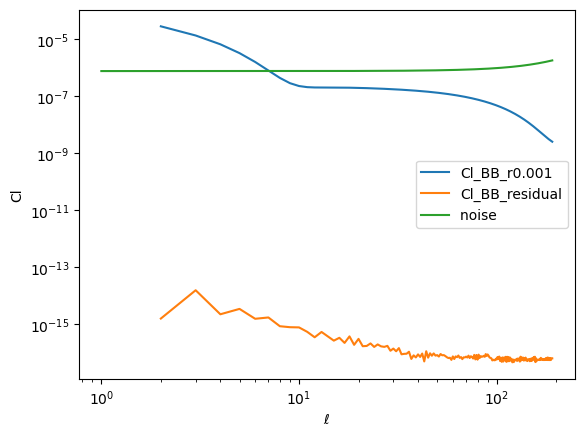

In [1725]:
lmin= 2
lmax= 192
ell = np.arange(lmin,lmax)

plt.loglog(ell, Cl_BB_r_001, label = "Cl_BB_r0.001") 
plt.loglog(ell, Cl_BB_residual, label = "Cl_BB_residual")



lmin= 1
lmax= 192
ell = np.arange(lmin,lmax)

plt.loglog(ell, noise , label = "noise ")
# plt.loglog(ell, bias , label = "bias")
# plt.loglog(ell, stat , label = "stat")
# plt.loglog(ell,var, label = "var")
# plt.loglog(ell,noise_stat, label = "noise+stat")

plt.xlabel(r'$\ell$')
plt.ylabel(r'Cl')
plt.legend()

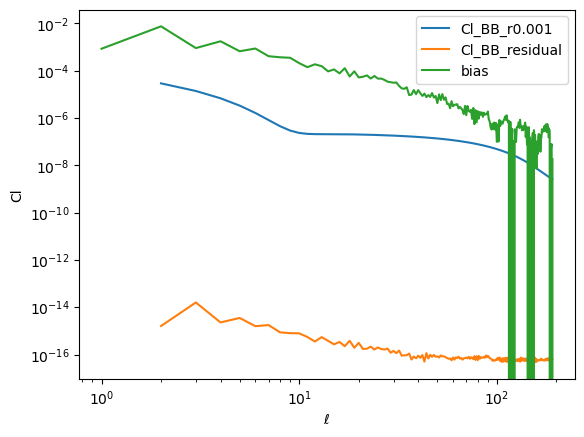

In [1726]:
lmin= 2
lmax= 192
ell = np.arange(lmin,lmax)

plt.loglog(ell, Cl_BB_r_001, label = "Cl_BB_r0.001") 
plt.loglog(ell, Cl_BB_residual, label = "Cl_BB_residual")



lmin= 1
lmax= 192
ell = np.arange(lmin,lmax)

#plt.loglog(ell, noise , label = "noise ")
plt.loglog(ell, bias , label = "bias")
# plt.loglog(ell, stat , label = "stat")
# plt.loglog(ell,var, label = "var")
# plt.loglog(ell,noise_stat, label = "noise+stat")

plt.xlabel(r'$\ell$')
plt.ylabel(r'Cl')
plt.legend()

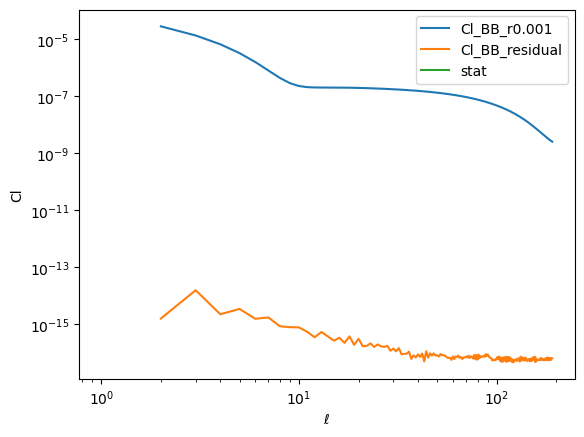

In [1727]:
lmin= 2
lmax= 192
ell = np.arange(lmin,lmax)

plt.loglog(ell, Cl_BB_r_001, label = "Cl_BB_r0.001") 
plt.loglog(ell, Cl_BB_residual, label = "Cl_BB_residual")



lmin= 0
lmax= 191
ell = np.arange(lmin,lmax)

#plt.loglog(ell, noise , label = "noise ")
# plt.loglog(ell, bias , label = "bias")
plt.loglog(ell, stat , label = "stat")
# plt.loglog(ell,var, label = "var")
# plt.loglog(ell,noise_stat, label = "noise+stat")

plt.xlabel(r'$\ell$')
plt.ylabel(r'Cl')
plt.legend()

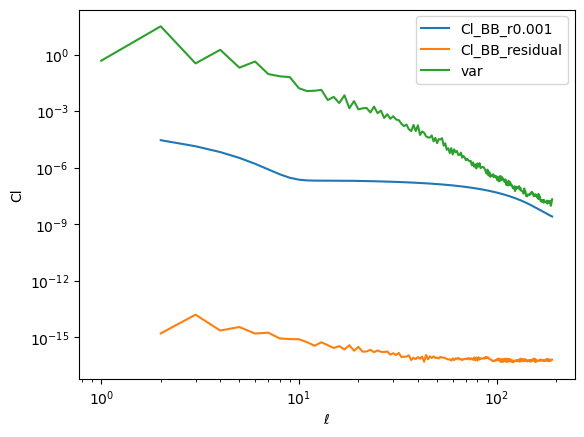

In [1728]:
lmin= 2
lmax= 192
ell = np.arange(lmin,lmax)

plt.loglog(ell, Cl_BB_r_001, label = "Cl_BB_r0.001") 
plt.loglog(ell, Cl_BB_residual, label = "Cl_BB_residual")



lmin= 1
lmax= 192
ell = np.arange(lmin,lmax)

#plt.loglog(ell, noise , label = "noise ")
# plt.loglog(ell, bias , label = "bias")
# plt.loglog(ell, stat , label = "stat")
plt.loglog(ell,var, label = "var")
# plt.loglog(ell,noise_stat, label = "noise+stat")

plt.xlabel(r'$\ell$')
plt.ylabel(r'Cl')
plt.legend()

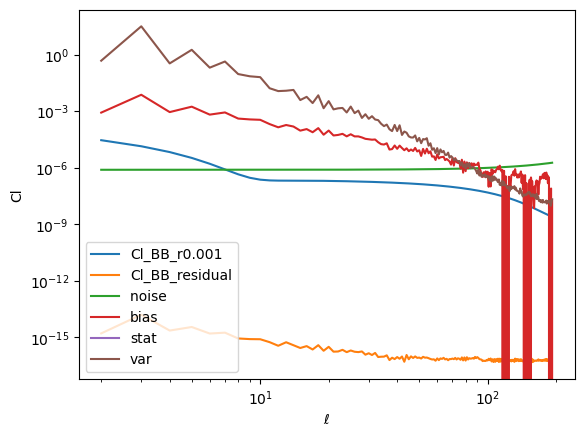

In [1729]:
lmin= 2
lmax= 192
ell = np.arange(lmin,lmax)

plt.loglog(ell, Cl_BB_r_001, label = "Cl_BB_r0.001") 
plt.loglog(ell, Cl_BB_residual, label = "Cl_BB_residual")



lmin= 2
lmax= 193
ell = np.arange(lmin,lmax)

plt.loglog(ell, noise , label = "noise ")
plt.loglog(ell, bias , label = "bias")
plt.loglog(ell, stat , label = "stat")
plt.loglog(ell,var, label = "var")
#plt.loglog(ell,noise_stat, label = "noise+stat")

plt.xlabel(r'$\ell$')
plt.ylabel(r'Cl')
plt.legend()